# Wavenet report plots

This notebook reproduces the figures in the Solid Earth paper which show the WaveNet and inverse WaveNet results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from analysis import load_model, load_testdataset

import sys
sys.path.insert(0, '../shared_modules/')
import processing_utils

sys.path.insert(0, '../pyray')
from model_gather import model_gather

In [2]:
# Global constants
DT = 0.002
T_GAIN = 2.5
DX = 5.
DZ = 5.
NSTEPS = 512
NZ = 128-14 # velocity traces have been pre-processed
NREC = 11
DELTARECi=10

gain = np.arange(NSTEPS)**T_GAIN
gain = gain / np.median(gain)

letters = ["a","b","c","d"]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

## Forward

In [3]:
# Load model and dataset
tf.reset_default_graph()
model, c_dict, input_features, sess = load_model("new_forward_final", verbose=False)
d = load_testdataset("layers_2ms_validate.bin", N_EXAMPLES=1000, c_dict=c_dict, verbose=False)

# Get batches of test data
velocity_array, reflectivity_array, gather_array = d[42,7,8,9]
print(velocity_array.shape, reflectivity_array.shape, gather_array.shape)

# Inference
gather_prediction_array = sess.run(model.y, feed_dict={input_features["reflectivity"]: reflectivity_array})

Loading model from: server/models/new_forward_final/model.ckpt-500000




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from server/models/new_forward_final/model.ckpt-500000
(4, 114, 1) (4, 512, 1) (4, 512, 11)


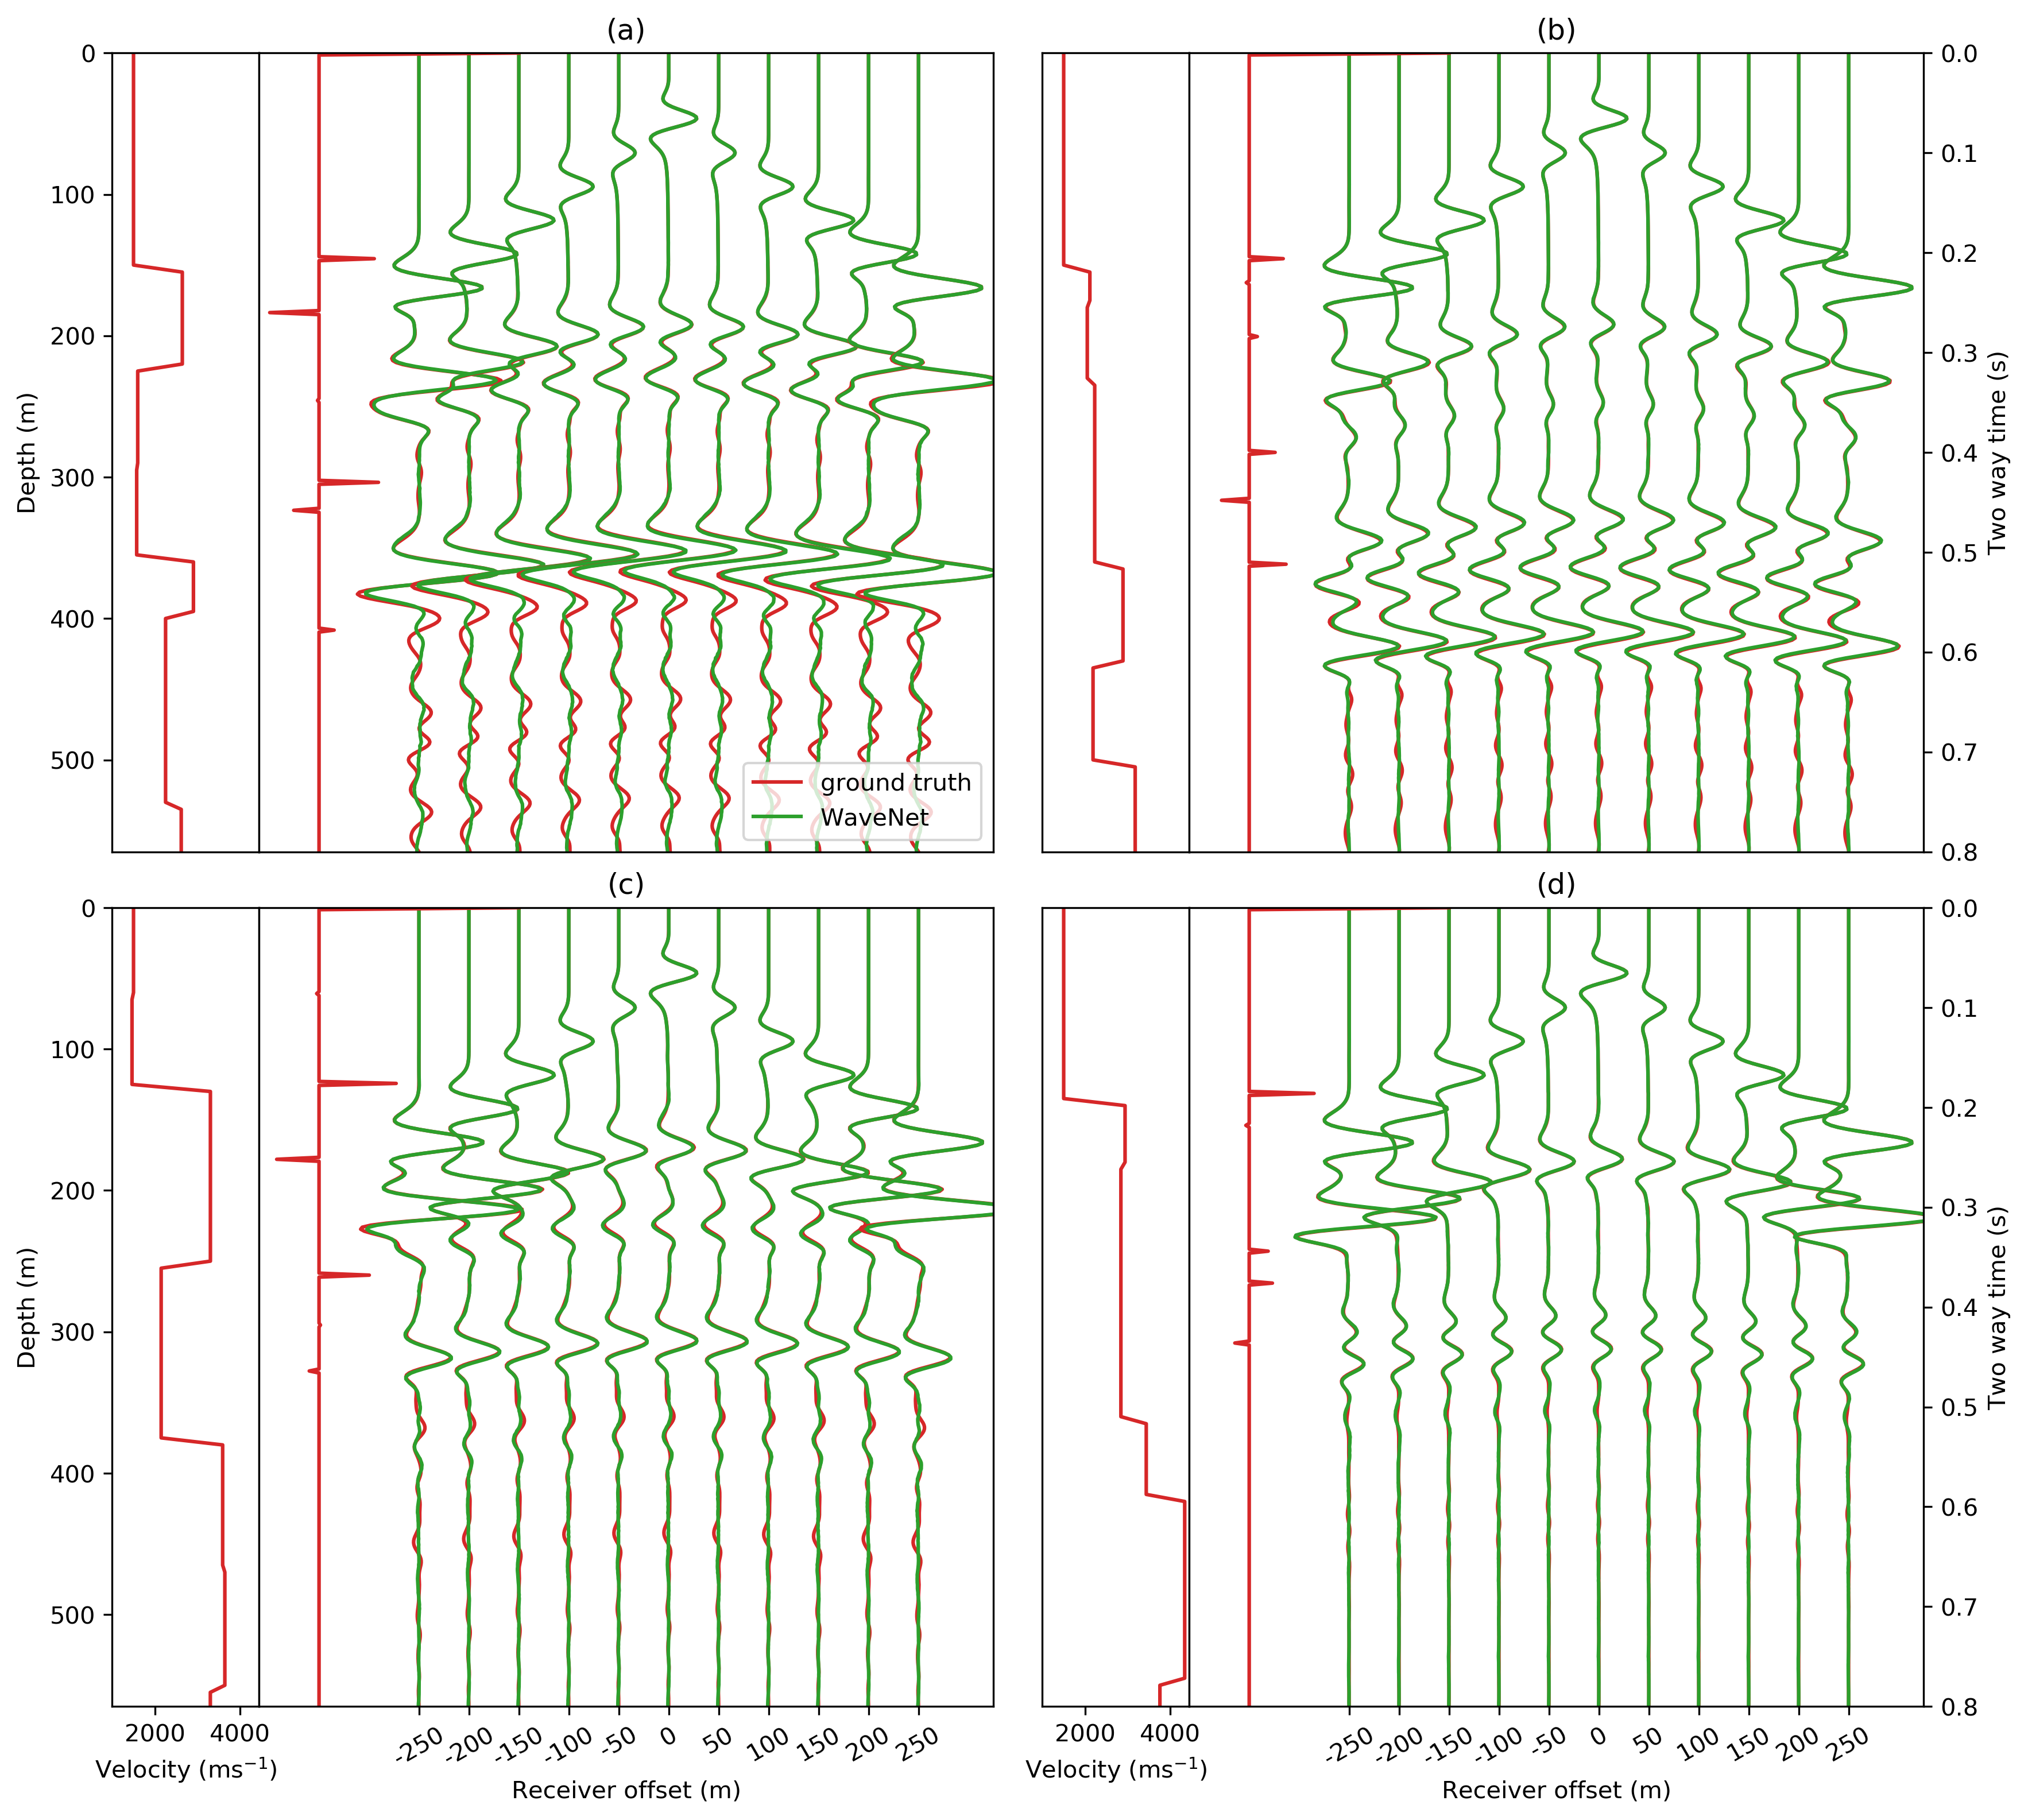

In [4]:
plt.figure(figsize=(12,12), dpi=300)

row_n = 0
for i,ib in enumerate([0,1,2,3]):
    if i == 2:
        row_n = 1
        i = 0
    if i == 3:
        i = 1
    
    # velocity
    plt.subplot2grid((2, 38), (row_n, 0+15*i+3*i+i), colspan=3)
    plt.plot(velocity_array[ib,:,0], DZ*np.arange(NZ), color='tab:red')
    
    plt.gca().invert_yaxis()
    if row_n == 1: plt.xlabel("Velocity ($\mathrm{ms}^{-1}$)")
    else: plt.xticks([])
    plt.xlim(1000,4450)
    plt.ylim(DZ*(NZ-1),0)
    if i==0: plt.ylabel("Depth (m)")
    else: plt.yticks([])
    
    
    # gather & reflectivity
    lim = 1.
    plt.subplot2grid((2, 38), (row_n, 3+15*i+3*i+i), colspan=15)
    for ir in range(NREC): 
        if ib == ir == 0:
            label1="ground truth"
            label2="WaveNet"
        else: label1 = label2 = None
                    
        plt.plot(lim*ir+gain*gather_array[ib,:,ir], DT*np.arange(NSTEPS), color='tab:red',label=label1)
        plt.plot(lim*ir+gain*gather_prediction_array[ib,:,ir], DT*np.arange(NSTEPS), color='tab:green',label=label2)
    
    plt.plot(-2*lim+4*reflectivity_array[ib,:,0], DT*np.arange(NSTEPS), color='tab:red')
    
    if ib == 0: plt.legend(loc=4)
    plt.title("(%s)"%(letters[ib]))
    plt.gca().invert_yaxis()
    if row_n == 1: 
        plt.xlabel("Receiver offset (m)")
        plt.xticks(np.arange(0, NREC*lim,lim), [int(-(NREC-1)*DELTARECi*DX/2 + irec*DELTARECi*DX) for irec in range(NREC)])
    else: plt.xticks([])
    if i==1: plt.ylabel("Two way time (s)")
    else: plt.yticks([])
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    plt.ylim(DT*400,0)
    plt.xlim(-3*lim-0.2, lim*(NREC-1)+lim+0.5)
    plt.xticks(rotation=30)

plt.subplots_adjust(left=0.1, right=1., bottom=0.1, top=.9, hspace=0.07, wspace=0.)
plt.savefig("../report_plots/fig04.pdf", bbox_inches='tight', pad_inches=0.01, dpi=300)

## Forward raytrace 2D

In [5]:
# Load model and dataset
tf.reset_default_graph()
model, c_dict, input_features, sess = load_model("new_forward_final", verbose=False)
d = load_testdataset("layers_2ms_validate.bin", N_EXAMPLES=1000, c_dict=c_dict, verbose=False)

# Get batches of test data
velocity_array, reflectivity_array, gather_array = d[:]
print(velocity_array.shape, reflectivity_array.shape, gather_array.shape)

# Inference
gather_prediction_array = sess.run(model.y, feed_dict={input_features["reflectivity"]: reflectivity_array})

Loading model from: server/models/new_forward_final/model.ckpt-500000
INFO:tensorflow:Restoring parameters from server/models/new_forward_final/model.ckpt-500000
(1000, 114, 1) (1000, 512, 1) (1000, 512, 11)


In [6]:
## RAY TRACING

source = np.load("../generate_data/gather/source/gather_00000000_00000000.npy")[5]
print(source.shape)

x_receivers = DX*(DELTARECi*(np.arange(NREC)-NREC//2))
conv2d = np.zeros(gather_array.shape)
for ib in range(reflectivity_array.shape[0]):
    
    v0 = velocity_array[ib,:,0]
    ilayers = np.argwhere(np.diff(v0))[:,0]# ilayers stores left indices of interface (lower velocity value)
    v = np.concatenate([v0[ilayers],np.array([v0[-1]])],axis=0)
    z = np.concatenate([np.array([0]),DZ*(ilayers+1),np.array([DZ*NZ])], axis=0)# use right edges to define layer height
    rho = 2200*np.ones_like(v)
    dz = np.diff(z)
    assert len(dz) == len(v)
    
    if len(v): xs,dzs,vs,ps,rs = model_gather(dz,v,rho,0,0,x_receivers,DT,NSTEPS)
    else: rs = np.zeros((NREC,NSTEPS), dtype=float)

    conv2d[ib] = (rs.T).copy()

# SOURCE CONVOLUTION

for ib in range(velocity_array.shape[0]):
    for ir in range(NREC):
        conv2d[ib,:,ir] = 1.5*processing_utils.convolve_source(conv2d[ib,:,ir], source)
        
# LOSS (averaged over gather)

loss_conv2d = np.mean(np.abs(gain.reshape((1,NSTEPS,1))*(conv2d - gather_array)), axis=(1,2))# l1 loss  

(512,)


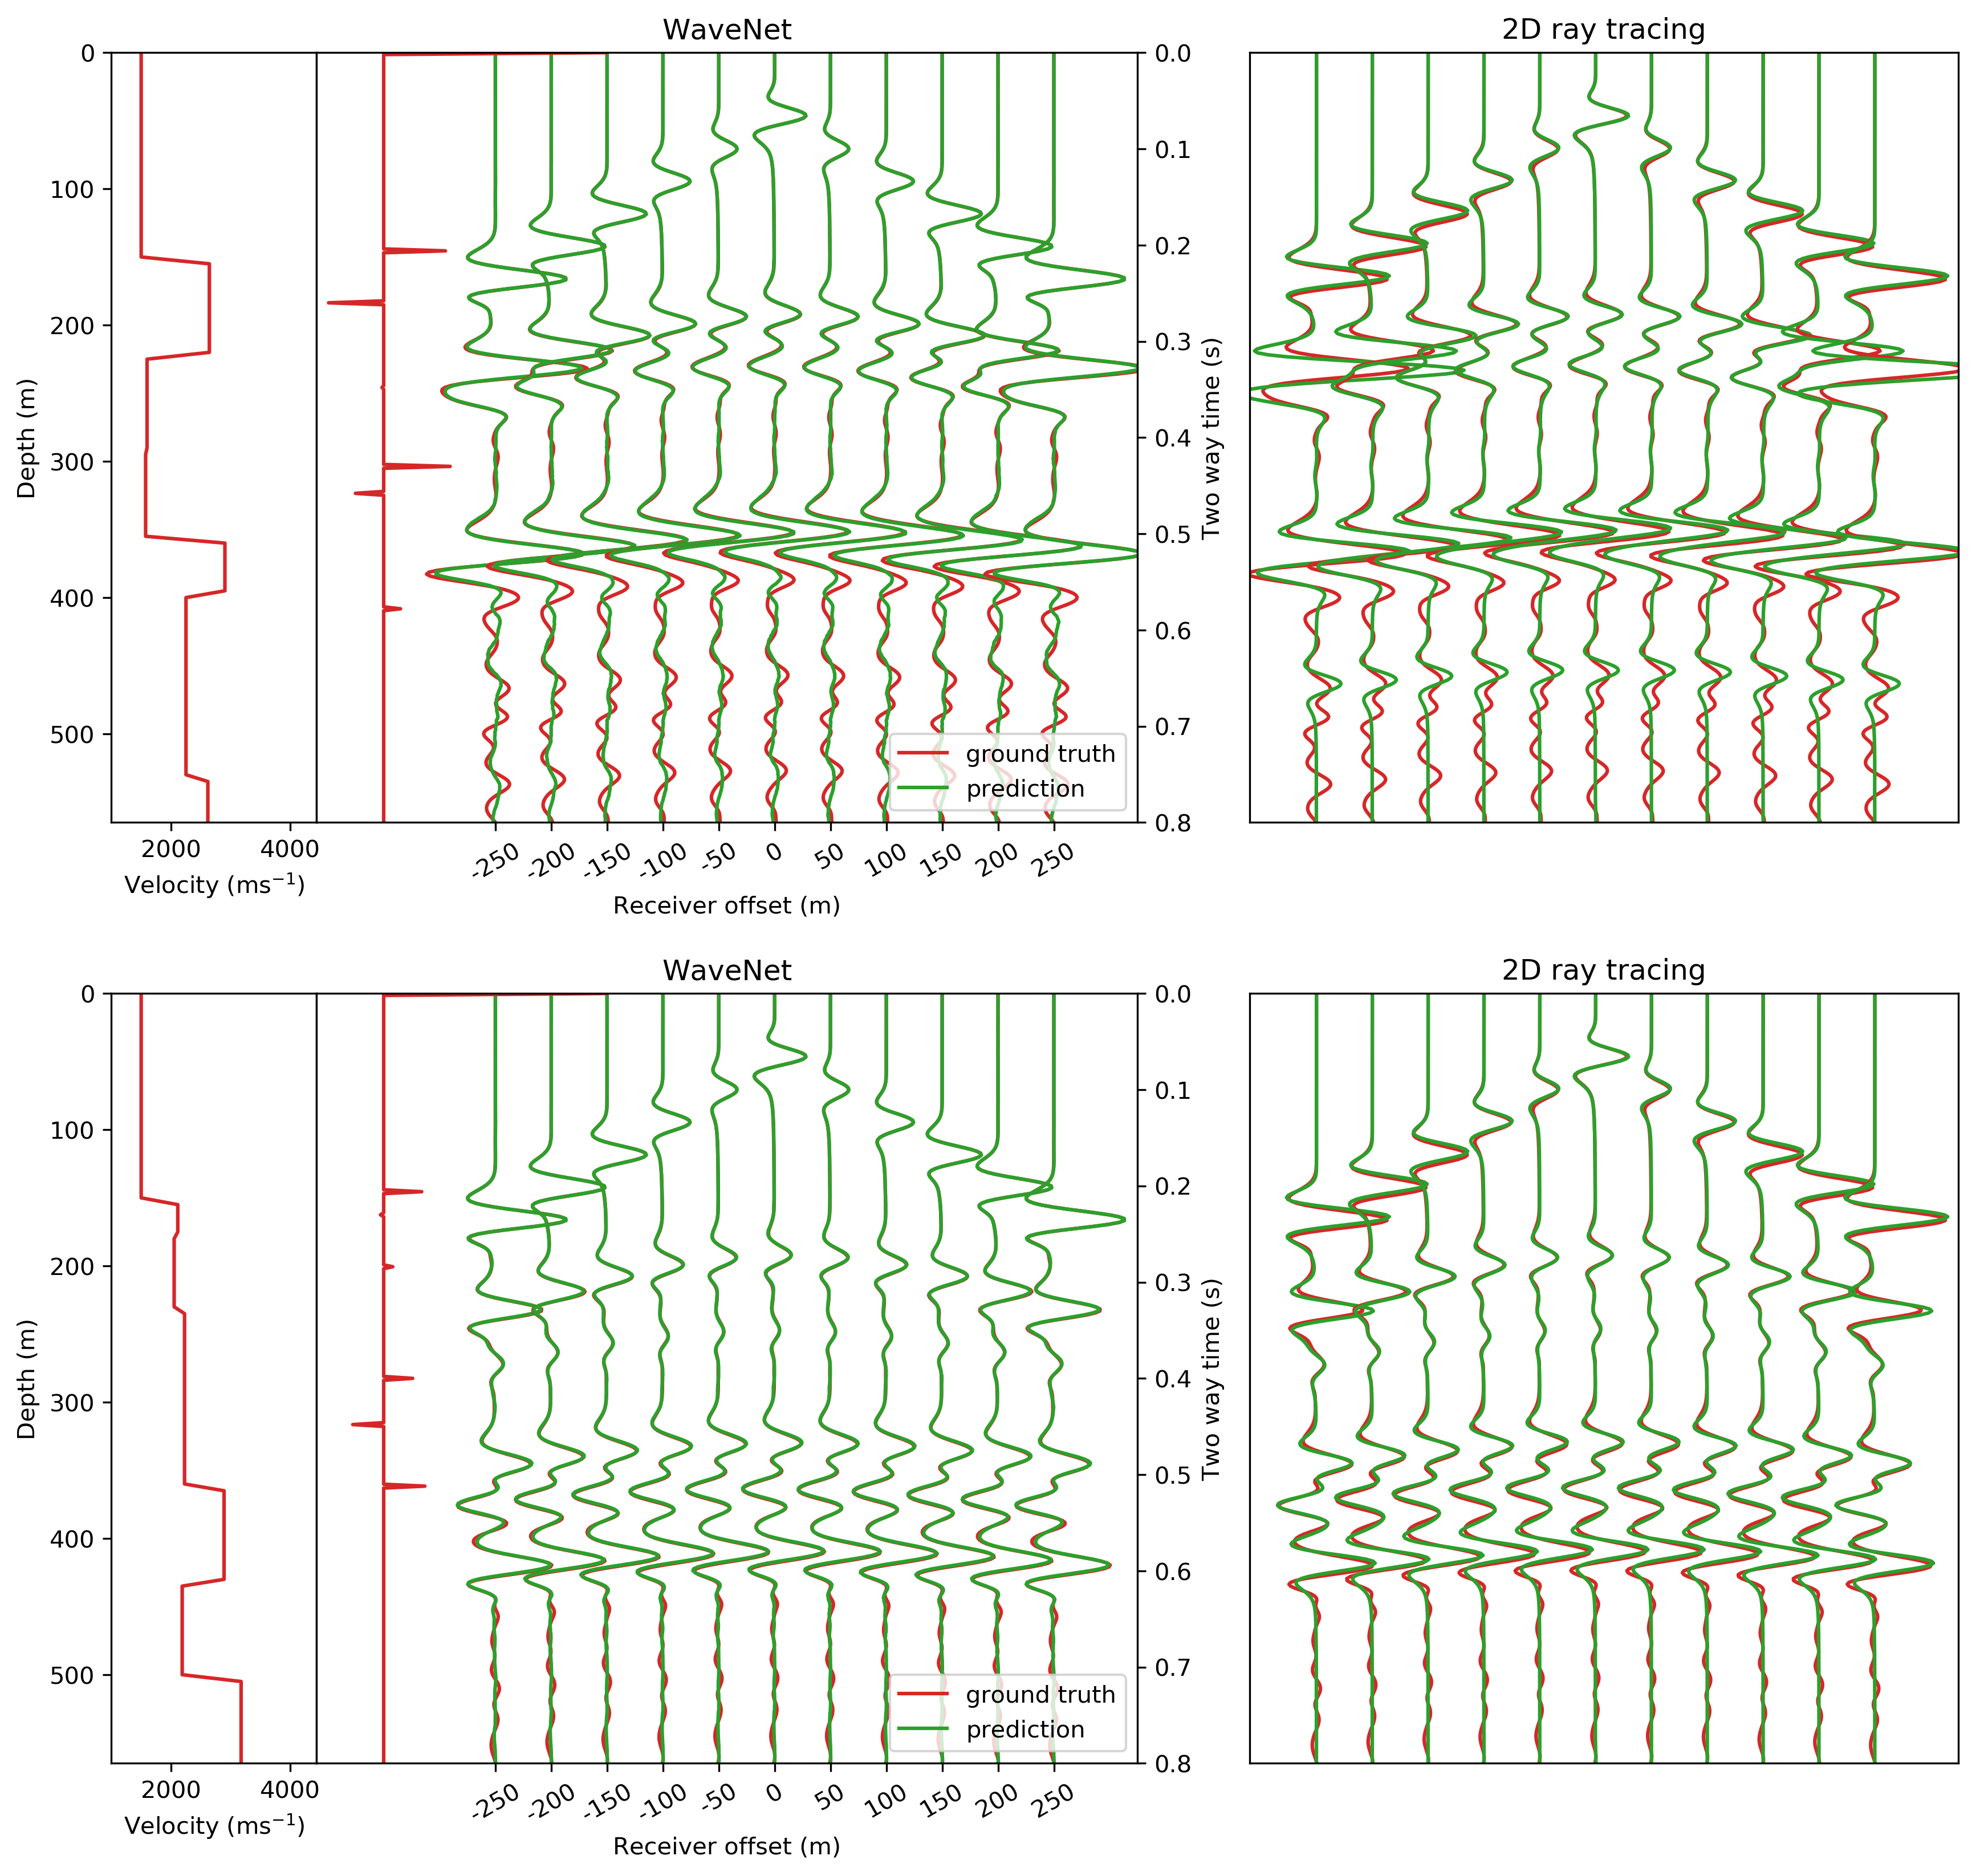

In [7]:
gather_prediction_arrays = [gather_prediction_array, conv2d]
names = ["WaveNet","2D ray tracing"]

def plot_gather(iname, ib, label=True, reflectivity=True, xlabel=True, ylabel=True):
    
    # gather & reflectivity
    lim = 1.
    for ir in range(NREC): 
        if label and ir==0:
            label1="ground truth"
            label2="prediction"
        else: label1 = label2 = None
        
        plt.plot(lim*ir+gain*gather_array[ib,:,ir], DT*np.arange(NSTEPS), color='tab:red',label=label1)
        plt.plot(lim*ir+gain*gather_prediction_arrays[iname][ib,:,ir], DT*np.arange(NSTEPS), color='tab:green',label=label2)
    
    if reflectivity:
        plt.plot(-2*lim+4*reflectivity_array[ib,:,0], DT*np.arange(NSTEPS), color='tab:red')
    
    if label:
        plt.legend(loc=4)
    plt.title(names[iname])
    
    plt.gca().invert_yaxis()
    if xlabel:
        plt.xlabel("Receiver offset (m)")
        plt.xticks(np.arange(0, NREC*lim,lim), [int(-(NREC-1)*DELTARECi*DX/2 + irec*DELTARECi*DX) for irec in range(NREC)])
    else: 
        plt.xticks([])
    if ylabel:
        plt.ylabel("Two way time (s)")
    else: 
        plt.yticks([])
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    plt.ylim(DT*400,0)
    if reflectivity:
        plt.xlim(-3*lim-0.2, lim*(NREC-1)+lim+0.5)
    else: 
        plt.xlim(-1*lim-0.2, lim*(NREC-1)+lim+0.5)
    plt.xticks(rotation=30)
    
    
f = plt.figure(figsize=(12,10), dpi=300)

# velocity axis
ax = f.add_axes([0,0.55,
                 0.1,0.45])# xmin, ymin, dx, and dy
plt.plot(velocity_array[42,:,0], DZ*np.arange(NZ), color='tab:red')
plt.gca().invert_yaxis()
plt.xlabel("Velocity ($\mathrm{ms}^{-1}$)")
plt.xlim(1000,4450)
plt.ylim(DZ*(NZ-1),0)
plt.ylabel("Depth (m)")

# gathers

ax = f.add_axes([0.1, 0.55,
                 0.4,0.45])# xmin, ymin, dx, and dy
plot_gather(0, 42)
    
ax = f.add_axes([0.5+0.0545,0.55,
                 0.4-0.0545,0.45])# xmin, ymin, dx, and dy
plot_gather(1, 42, reflectivity=False, xlabel=False, ylabel=False, label=False)


# velocity axis
ax = f.add_axes([0,0.,
                 0.1,0.45])# xmin, ymin, dx, and dy
plt.plot(velocity_array[7,:,0], DZ*np.arange(NZ), color='tab:red')
plt.gca().invert_yaxis()
plt.xlabel("Velocity ($\mathrm{ms}^{-1}$)")
plt.xlim(1000,4450)
plt.ylim(DZ*(NZ-1),0)
plt.ylabel("Depth (m)")


ax = f.add_axes([0.1, 0.,
                 0.4,0.45])# xmin, ymin, dx, and dy
plot_gather(0, 7)
    
ax = f.add_axes([0.5+0.0545,0.,
                 0.4-0.0545,0.45])# xmin, ymin, dx, and dy
plot_gather(1, 7, reflectivity=False, xlabel=False, ylabel=False, label=False)


plt.savefig("../report_plots/fig05.pdf", bbox_inches='tight', pad_inches=0.01, dpi=300)

## Forward conv1d

In [8]:
# Load model and dataset
tf.reset_default_graph()
model, c_dict, input_features, sess = load_model("new_forward_final", verbose=False)
d = load_testdataset("layers_2ms_validate.bin", N_EXAMPLES=1000, c_dict=c_dict, verbose=False)

# Get batches of test data
velocity_array, reflectivity_array, gather_array = d[:]
print(velocity_array.shape, reflectivity_array.shape, gather_array.shape)

# Inference
gather_prediction_array = sess.run(model.y, feed_dict={input_features["reflectivity"]: reflectivity_array})

Loading model from: server/models/new_forward_final/model.ckpt-500000
INFO:tensorflow:Restoring parameters from server/models/new_forward_final/model.ckpt-500000
(1000, 114, 1) (1000, 512, 1) (1000, 512, 11)


In [9]:
# 1D convolutional model to compare to
conv1d = np.zeros(reflectivity_array.shape)
source = np.load("../generate_data/gather/source/gather_00000000_00000000.npy")[5]
for ib in range(reflectivity_array.shape[0]):
    conv1d[ib,:,0] = processing_utils.convolve_source(reflectivity_array[ib,:,0], source)/15.

In [10]:
#get losses (averaged over gather)
n_examples = gather_prediction_array.shape[0]

loss1 = np.mean(np.abs(gain*(gather_prediction_array[:,:,5] - gather_array[:,:,5])), axis=1)# l1 loss
loss2 = np.mean(np.abs(gain*(conv1d[:,:,0] - gather_array[:,:,5])), axis=1)# l1 loss
print(loss1.shape, loss2.shape)

(1000,) (1000,)


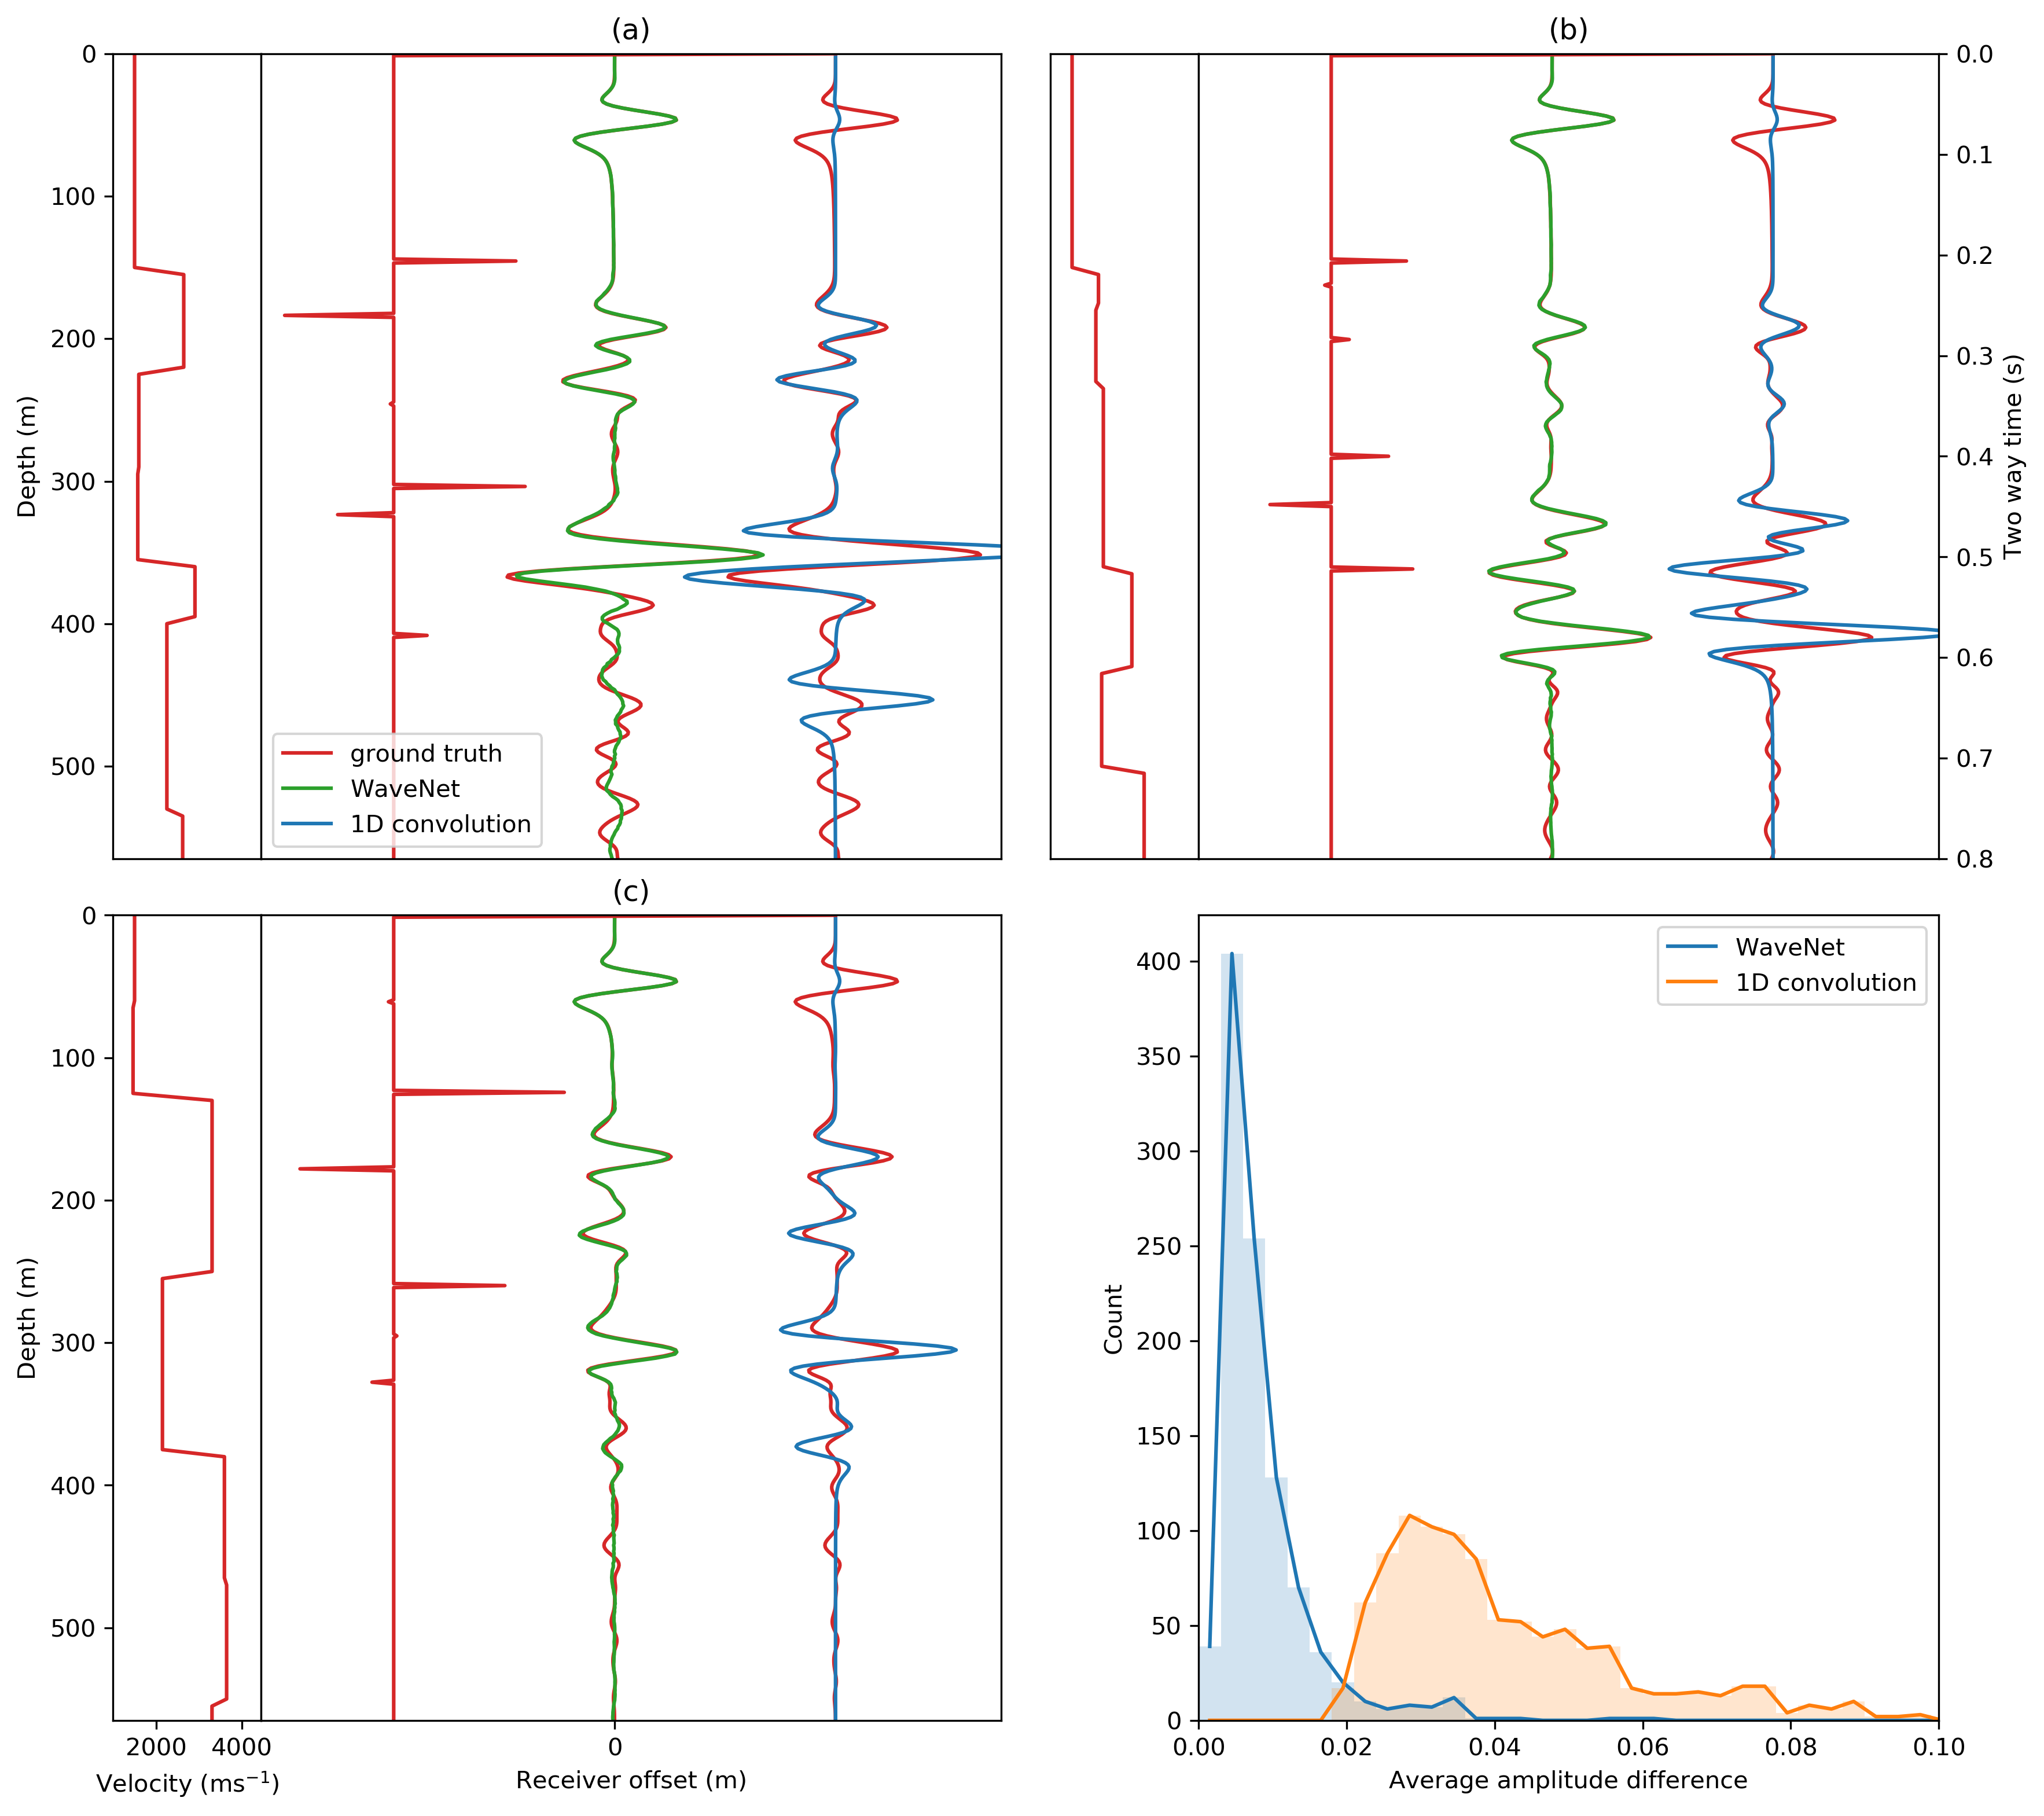

In [11]:
plt.figure(figsize=(12,12), dpi=300)

row_n = 0
for i,ib in enumerate([42,7,8,9]):
    ii = i
    if i == 2:
        row_n = 1
        i = 0
    if i == 3:
        i = 1
    
    if row_n==0 or i==0:
        
        # velocity
        plt.subplot2grid((2, 38), (row_n, 0+15*i+3*i+i), colspan=3)
        plt.plot(velocity_array[ib,:,0], DZ*np.arange(NZ), color='tab:red')
        
        plt.gca().invert_yaxis()
        if row_n == 1: plt.xlabel("Velocity ($\mathrm{ms}^{-1}$)")
        else: plt.xticks([])
        plt.xlim(1000,4450)
        plt.ylim(DZ*(NZ-1),0)
        if i==0: plt.ylabel("Depth (m)")
        else: plt.yticks([])
    
    
    # gather & reflectivity
    lim = 1.
    plt.subplot2grid((2, 38), (row_n, 3+15*i+3*i+i), colspan=15)
    if ii == 0:
        label1="ground truth"
        label2="WaveNet"
        label3="1D convolution"
    else: label1 = label2 = None

    plt.plot(lim*0+gain*gather_array[ib,:,5], DT*np.arange(NSTEPS), color='tab:red',label=label1)
    plt.plot(lim*0+gain*gather_prediction_array[ib,:,5], DT*np.arange(NSTEPS), color='tab:green',label=label2)

    plt.plot(lim*2+gain*gather_array[ib,:,5], DT*np.arange(NSTEPS), color='tab:red')
    plt.plot(lim*2+gain*conv1d[ib,:,0], DT*np.arange(NSTEPS), color='tab:blue',label=label3)
    
    plt.plot(-2*lim+4*reflectivity_array[ib,:,0], DT*np.arange(NSTEPS), color='tab:red')
    
    if ii == 0: plt.legend(loc=3)
    plt.title("(%s)"%(letters[ii]))
    plt.gca().invert_yaxis()
    if row_n == 1: 
        plt.xlabel("Receiver offset (m)")
        plt.xticks([0])
    else: plt.xticks([])
    if i==1: plt.ylabel("Two way time (s)")
    else: plt.yticks([])
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    plt.ylim(DT*400,0)
    plt.xlim(-3*lim-0.2, lim*(2)+lim+0.5)

# loss
plt.subplot2grid((2, 38), (row_n, 3+15*1+3*1+1), colspan=15)

x = np.arange(0,0.2,0.003)
plt.plot(x[:-1]+(x[1]-x[0])/2.,np.histogram(loss1, bins=x)[0], label="WaveNet", color=colors[0])
plt.hist(loss1, bins=x, histtype='stepfilled', alpha=0.2, color=colors[0])
plt.plot(x[:-1]+(x[1]-x[0])/2.,np.histogram(loss2, bins=x)[0], label="1D convolution", color=colors[1])
plt.hist(loss2, bins=x, histtype='stepfilled', alpha=0.2, color=colors[1])


plt.xlim(0,0.1)
plt.ylabel("Count")
plt.xlabel("Average amplitude difference")
plt.legend(loc=1)


plt.subplots_adjust(left=0.1, right=1., bottom=0.1, top=.9, hspace=0.07, wspace=0.)
#plt.savefig("../report_plots/fig05.pdf", bbox_inches='tight', pad_inches=0.01, dpi=300)

## Forward multiple models

In [12]:
names = [("new_forward_final", "WaveNet"), 
         ("new_forward_final_cnn_dilated", "Dilated CNN"), 
         ("new_forward_final_cnn_flat", "CNN")]


# Load model and dataset
tf.reset_default_graph()
model, c_dict, input_features, sess = load_model(names[0][0], verbose=False)
d = load_testdataset("layers_2ms_validate.bin", N_EXAMPLES=1000, c_dict=c_dict, verbose=False)

# Get batches of test data
velocity_array, reflectivity_array, gather_array = d[:]
print(velocity_array.shape, reflectivity_array.shape, gather_array.shape)

gather_prediction_arrays, losses = [], []
for name in names:
    
    # Inference
    tf.reset_default_graph()
    model, c_dict, input_features, sess = load_model(name[0], verbose=False)
    
    print(model)
    
    gather_prediction_array = sess.run(model.y, feed_dict={input_features["reflectivity"]: reflectivity_array})
    
    gather_prediction_arrays.append(gather_prediction_array)
    print(gather_prediction_array.shape)
    
    # Calculate loss (averaged over gather)
    loss = np.mean(np.abs(gain.reshape((1,NSTEPS,1))*(gather_prediction_array - gather_array)), axis=(1,2))# l1 loss             
    losses.append(loss)

Loading model from: server/models/new_forward_final/model.ckpt-500000
INFO:tensorflow:Restoring parameters from server/models/new_forward_final/model.ckpt-500000
(1000, 114, 1) (1000, 512, 1) (1000, 512, 11)
Loading model from: server/models/new_forward_final/model.ckpt-500000
INFO:tensorflow:Restoring parameters from server/models/new_forward_final/model.ckpt-500000
Wavenet:
	Number of weights: 1049088
	Number of biases: 0
Conv1d:
	Number of weights: 284416
	Number of biases: 11
Total number of trainable parameters: 1333515
(1000, 512, 11)
Loading model from: server/models/new_forward_final_cnn_dilated/model.ckpt-500000
INFO:tensorflow:Restoring parameters from server/models/new_forward_final_cnn_dilated/model.ckpt-500000

Conv1d:
	Number of weights: 1385472
	Number of biases: 2059
Total number of trainable parameters: 1387531
(1000, 512, 11)
Loading model from: server/models/new_forward_final_cnn_flat/model.ckpt-500000
INFO:tensorflow:Restoring parameters from server/models/new_forwa

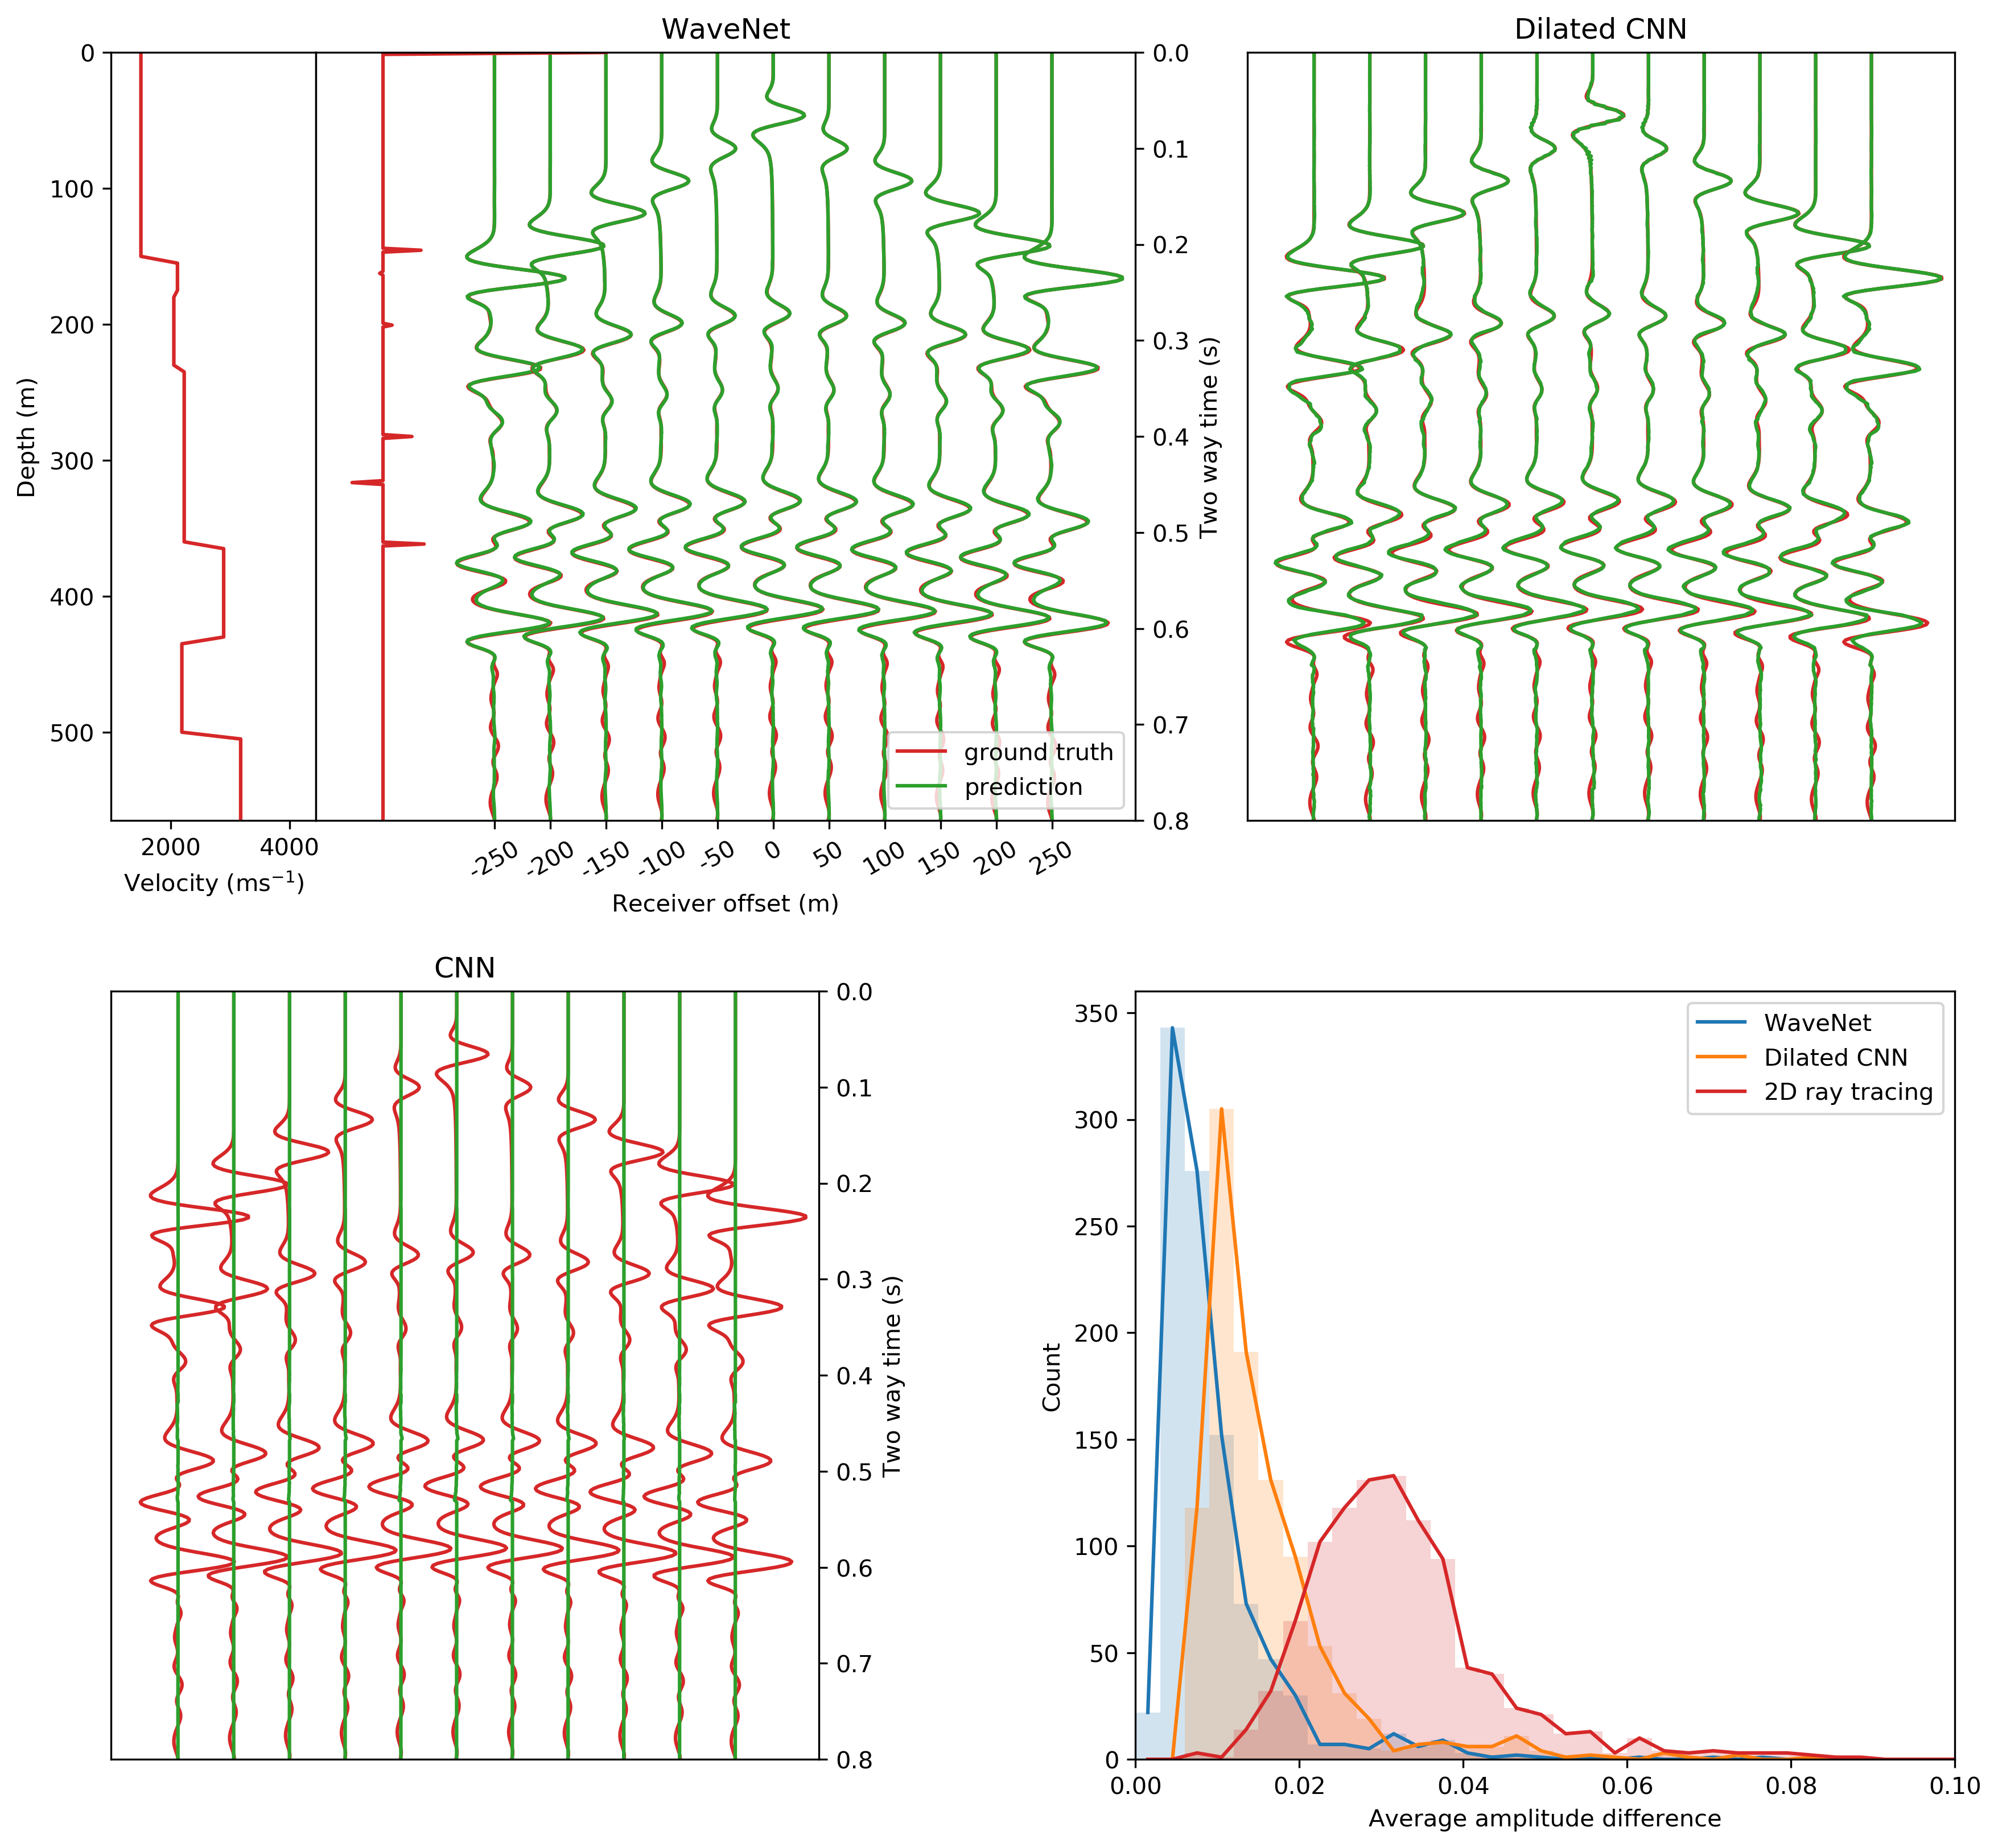

In [13]:
ib = 7

def plot_gather(iname, label=True, reflectivity=True, xlabel=True, ylabel=True):
    
    # gather & reflectivity
    lim = 1.
    for ir in range(NREC): 
        if label and ir==0:
            label1="ground truth"
            label2="prediction"
        else: label1 = label2 = None
        
        plt.plot(lim*ir+gain*gather_array[ib,:,ir], DT*np.arange(NSTEPS), color='tab:red',label=label1)
        plt.plot(lim*ir+gain*gather_prediction_arrays[iname][ib,:,ir], DT*np.arange(NSTEPS), color='tab:green',label=label2)
    
    if reflectivity:
        plt.plot(-2*lim+4*reflectivity_array[ib,:,0], DT*np.arange(NSTEPS), color='tab:red')
    
    if label:
        plt.legend(loc=4)
    plt.title(names[iname][1])
    
    plt.gca().invert_yaxis()
    if xlabel:
        plt.xlabel("Receiver offset (m)")
        plt.xticks(np.arange(0, NREC*lim,lim), [int(-(NREC-1)*DELTARECi*DX/2 + irec*DELTARECi*DX) for irec in range(NREC)])
    else: 
        plt.xticks([])
    if ylabel:
        plt.ylabel("Two way time (s)")
    else: 
        plt.yticks([])
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    plt.ylim(DT*400,0)
    if reflectivity:
        plt.xlim(-3*lim-0.2, lim*(NREC-1)+lim+0.5)
    else: 
        plt.xlim(-1*lim-0.2, lim*(NREC-1)+lim+0.5)
    plt.xticks(rotation=30)
    
    
f = plt.figure(figsize=(12,10), dpi=300)

# velocity axis
ax = f.add_axes([0,0.55,
                 0.1,0.45])# xmin, ymin, dx, and dy
plt.plot(velocity_array[ib,:,0], DZ*np.arange(NZ), color='tab:red')
plt.gca().invert_yaxis()
plt.xlabel("Velocity ($\mathrm{ms}^{-1}$)")
plt.xlim(1000,4450)
plt.ylim(DZ*(NZ-1),0)
plt.ylabel("Depth (m)")

# gathers
iname=0
ax = f.add_axes([0.1, 0.55,
                 0.4,0.45])# xmin, ymin, dx, and dy
plot_gather(iname)
    
iname=1
ax = f.add_axes([0.5+0.0545,0.55,
                 0.4-0.0545,0.45])# xmin, ymin, dx, and dy
plot_gather(iname, reflectivity=False, xlabel=False, ylabel=False, label=False)

iname=2
ax = f.add_axes([0.0, 0.,
                 0.4-0.0545,0.45])# xmin, ymin, dx, and dy
plot_gather(iname, reflectivity=False, xlabel=False, ylabel=True, label=False)
    
    
# loss
ax = f.add_axes([0.5,0.,
             0.4,0.45])# xmin, ymin, dx, and dy


# add in 2D conv loss above
names += [("", "2D ray tracing")]
losses.append(loss_conv2d)

for iname in [0,1,3]:
    x = np.arange(0,0.2,0.003)
    plt.plot(x[:-1]+(x[1]-x[0])/2.,np.histogram(losses[iname], bins=x)[0], label=names[iname][1], color=colors[iname])
    plt.hist(losses[iname], bins=x, histtype='stepfilled', alpha=0.2, color=colors[iname])
plt.xlim(0,0.1)
plt.legend()
plt.ylabel("Count")
plt.xlabel("Average amplitude difference")

plt.savefig("../report_plots/figA1.pdf", bbox_inches='tight', pad_inches=0.01, dpi=300)

## Inverse

In [14]:
# Load model and dataset
tf.reset_default_graph()
model, c_dict, input_features, sess = load_model("new_inverse_final", verbose=False)
d = load_testdataset("layers_2ms_validate.bin", N_EXAMPLES=1000, c_dict=c_dict, verbose=False)

# Get batches of test data
velocity_array, reflectivity_array, gather_array = d[42,7,8,9]
print(velocity_array.shape, reflectivity_array.shape, gather_array.shape)

# Inference
reflectivity_prediction_array = sess.run(model.y, feed_dict={input_features["gather"]: gather_array})

Loading model from: server/models/new_inverse_final/model.ckpt-500000
INFO:tensorflow:Restoring parameters from server/models/new_inverse_final/model.ckpt-500000
(4, 114, 1) (4, 512, 1) (4, 512, 11)


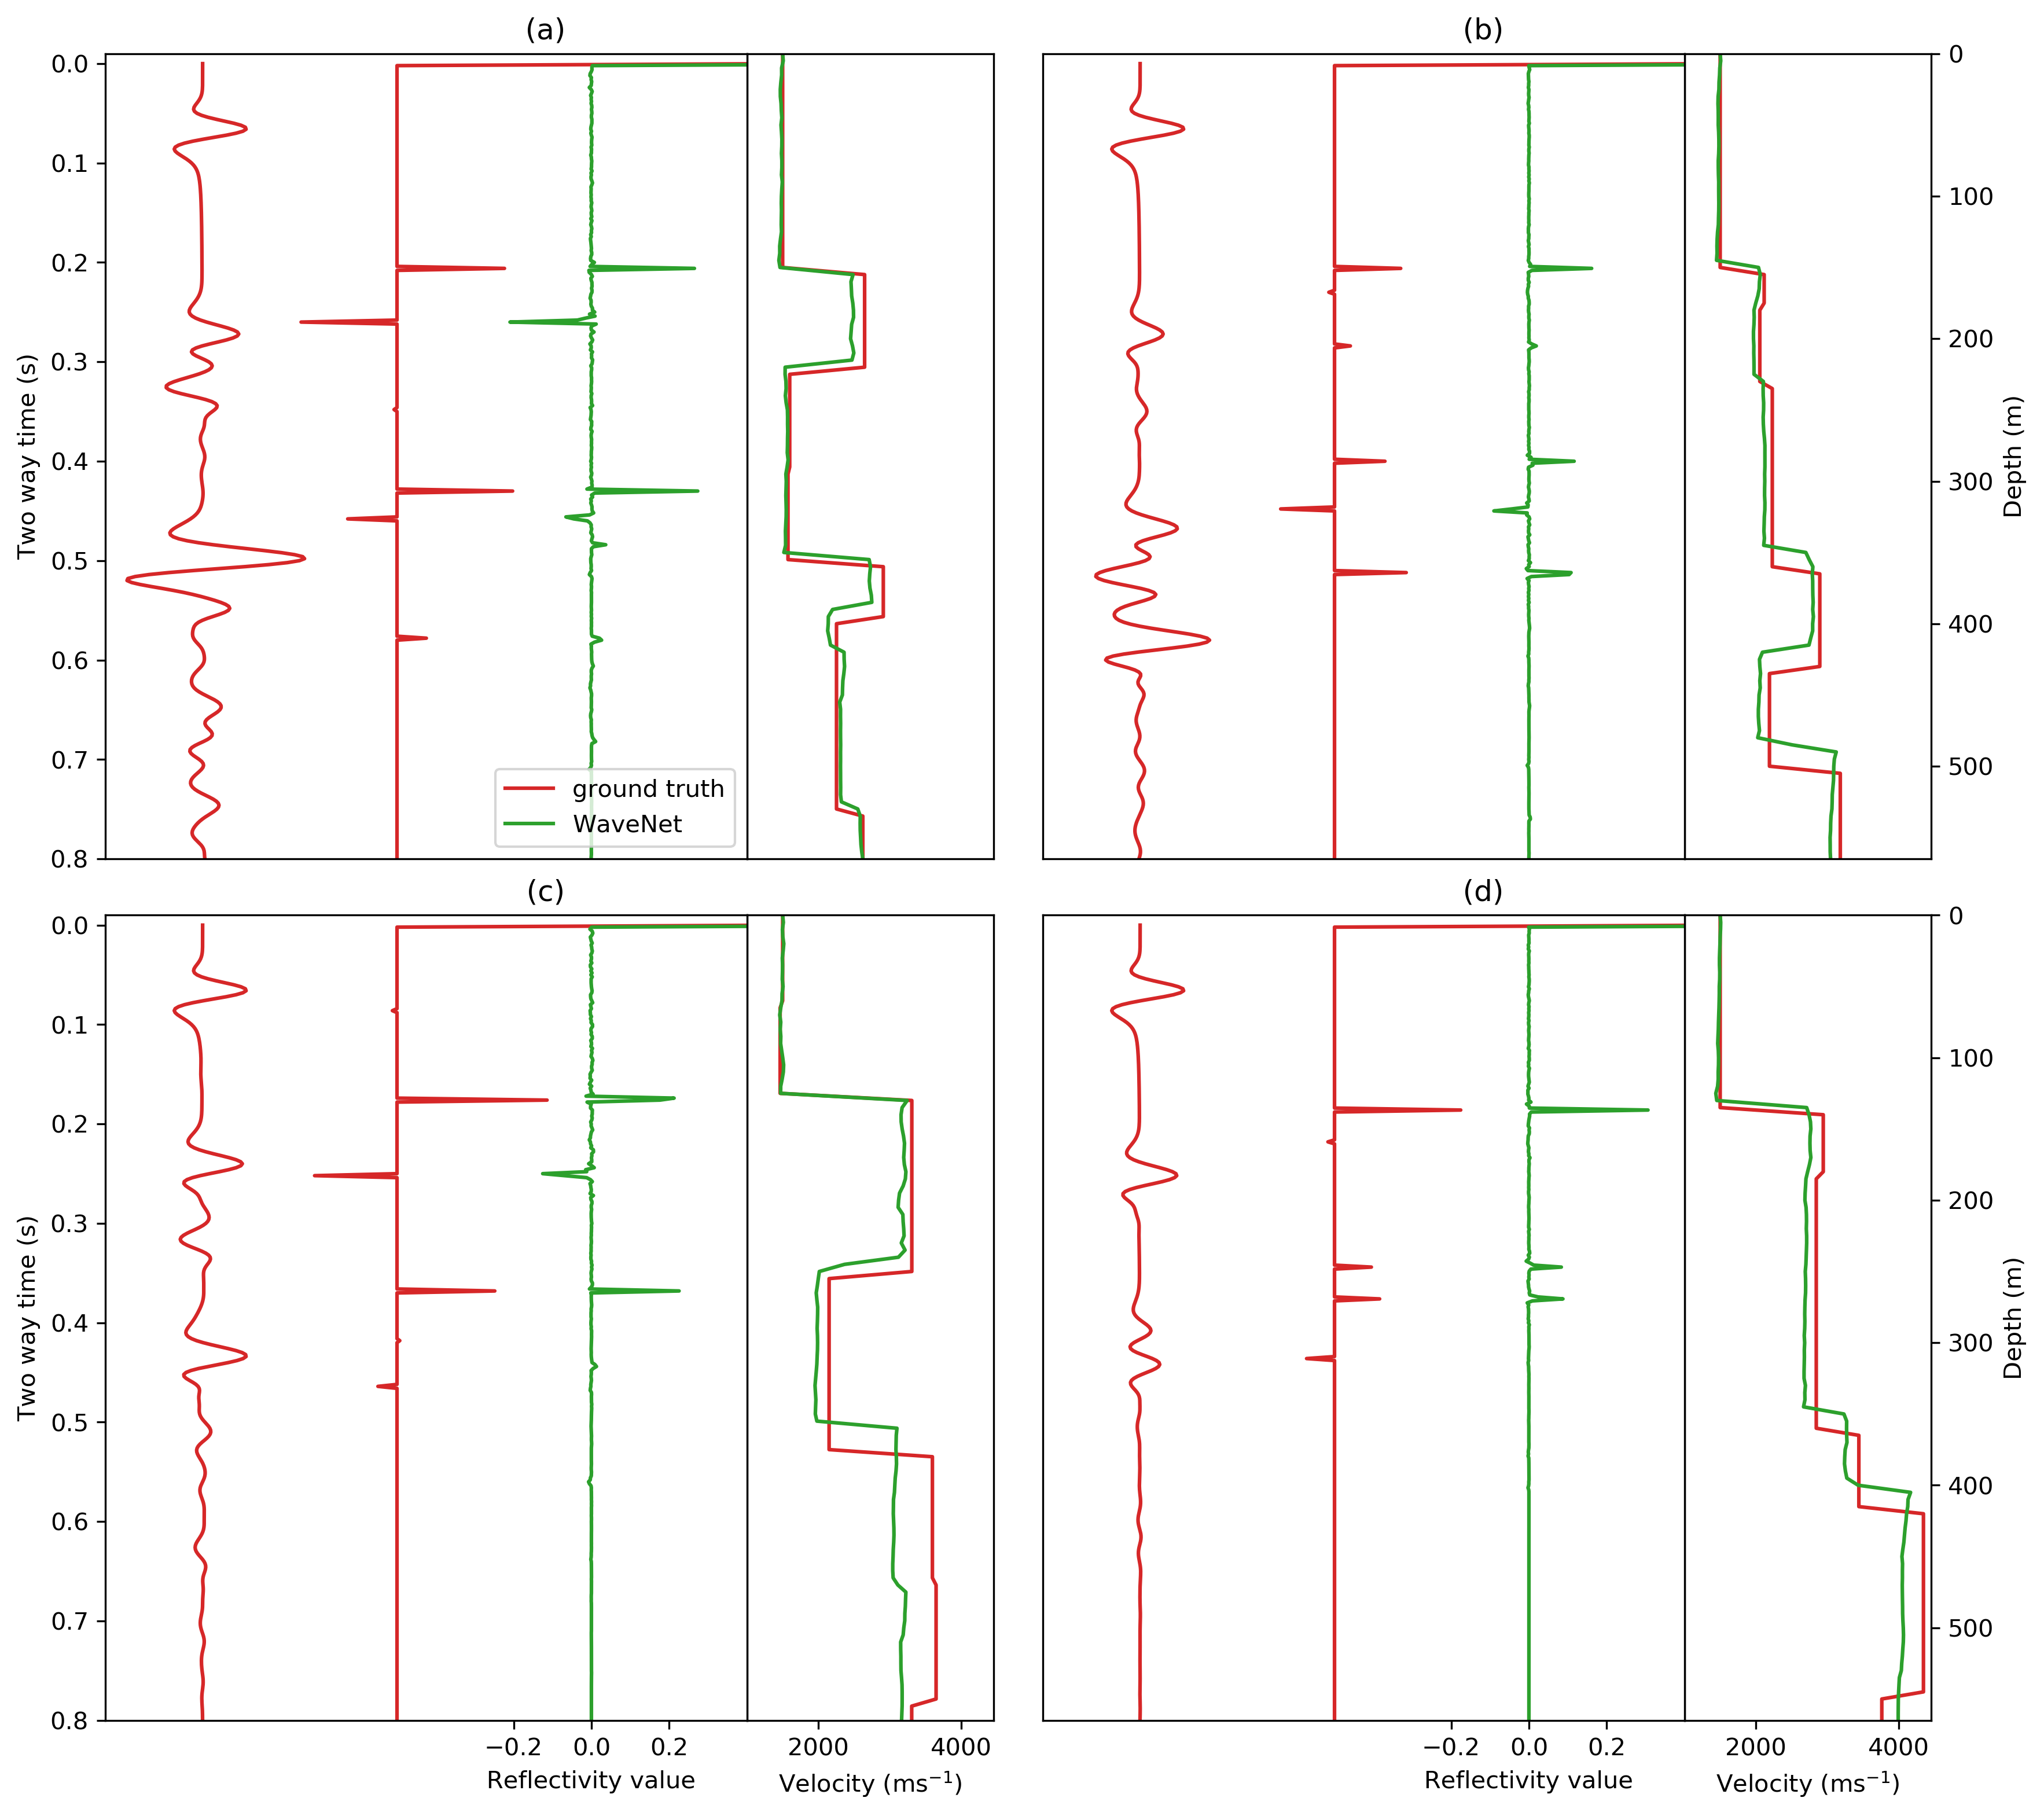

In [15]:
plt.figure(figsize=(12,12), dpi=300)

row_n = 0
for i,ib in enumerate([0,1,2,3]):
    if i == 2:
        row_n = 1
        i = 0
    if i == 3:
        i = 1
    
    v_d = processing_utils.get_velocity_trace(reflectivity_prediction_array[ib,:,0], 
                                              qc=False, srate=DT, DZ=DZ, NZ=NZ, v0=1500.)
    
    # velocity
    plt.subplot2grid((2, 38), (row_n, 13+13*i+5*i+i), colspan=5)
    
    plt.plot(velocity_array[ib,:,0], DZ*np.arange(NZ), color='tab:red',label="ground truth")
    plt.plot(v_d, DZ*np.arange(NZ), color='tab:green',label="WaveNet")
    
    plt.gca().invert_yaxis()
    if row_n == 1: plt.xlabel("Velocity ($\mathrm{ms}^{-1}$)")
    else: plt.xticks([])
    plt.xlim(1000,4450)
    plt.ylim(DZ*(NZ-1),0)
    if i==1: 
        plt.ylabel("Depth (m)")
        plt.gca().yaxis.tick_right()
        plt.gca().yaxis.set_label_position("right")
    else: plt.yticks([])
    
    # gather & reflectivity
    plt.subplot2grid((2, 38), (row_n, 0+13*i+5*i+i), colspan=13)
    if ib == 0:
        label1="ground truth"
        label2="WaveNet"
    else: label1 = label2 = None
    
    lim = 0.2
    plt.plot(-1+lim*gain*gather_array[ib,:,5], DT*np.arange(NSTEPS), color='tab:red',label=label1)
    plt.plot(-0.5+reflectivity_array[ib,:,0], DT*np.arange(NSTEPS), color='tab:red')
    plt.plot(0+reflectivity_prediction_array[ib,:,0], DT*np.arange(NSTEPS), color='tab:green',label=label2)
    if ib == 0: plt.legend(loc=4)
    
    plt.title("                          (%s)"%(letters[ib]))
    
    plt.gca().invert_yaxis()
    if row_n == 1: 
        plt.xlabel("                                           Reflectivity value")
        plt.xticks([-0.2, 0, 0.2])
    else: plt.xticks([])
    if i==0: plt.ylabel("Two way time (s)")
    else: plt.yticks([])
    plt.ylim(DT*400,-0.01)
    plt.xlim(-1-0.25, 0.4)

plt.subplots_adjust(left=0.1, right=1., bottom=0.1, top=.9, hspace=0.07, wspace=0.00)
plt.savefig("../report_plots/fig07.pdf", bbox_inches='tight', pad_inches=0.01, dpi=300)

# Forward generalisation (thinner models)

In [16]:
# Load model and dataset
tf.reset_default_graph()
model, c_dict, input_features, sess = load_model("new_forward_final", verbose=False)
d = load_testdataset("layers_generalisation_2ms.bin", N_EXAMPLES=1000, c_dict=c_dict, verbose=False)

# Get batches of test data
velocity_array, reflectivity_array, gather_array = d[0,1,2,3]
print(velocity_array.shape, reflectivity_array.shape, gather_array.shape)

# Inference
gather_prediction_array = sess.run(model.y, feed_dict={input_features["reflectivity"]: reflectivity_array})

Loading model from: server/models/new_forward_final/model.ckpt-500000
INFO:tensorflow:Restoring parameters from server/models/new_forward_final/model.ckpt-500000
(4, 114, 1) (4, 512, 1) (4, 512, 11)


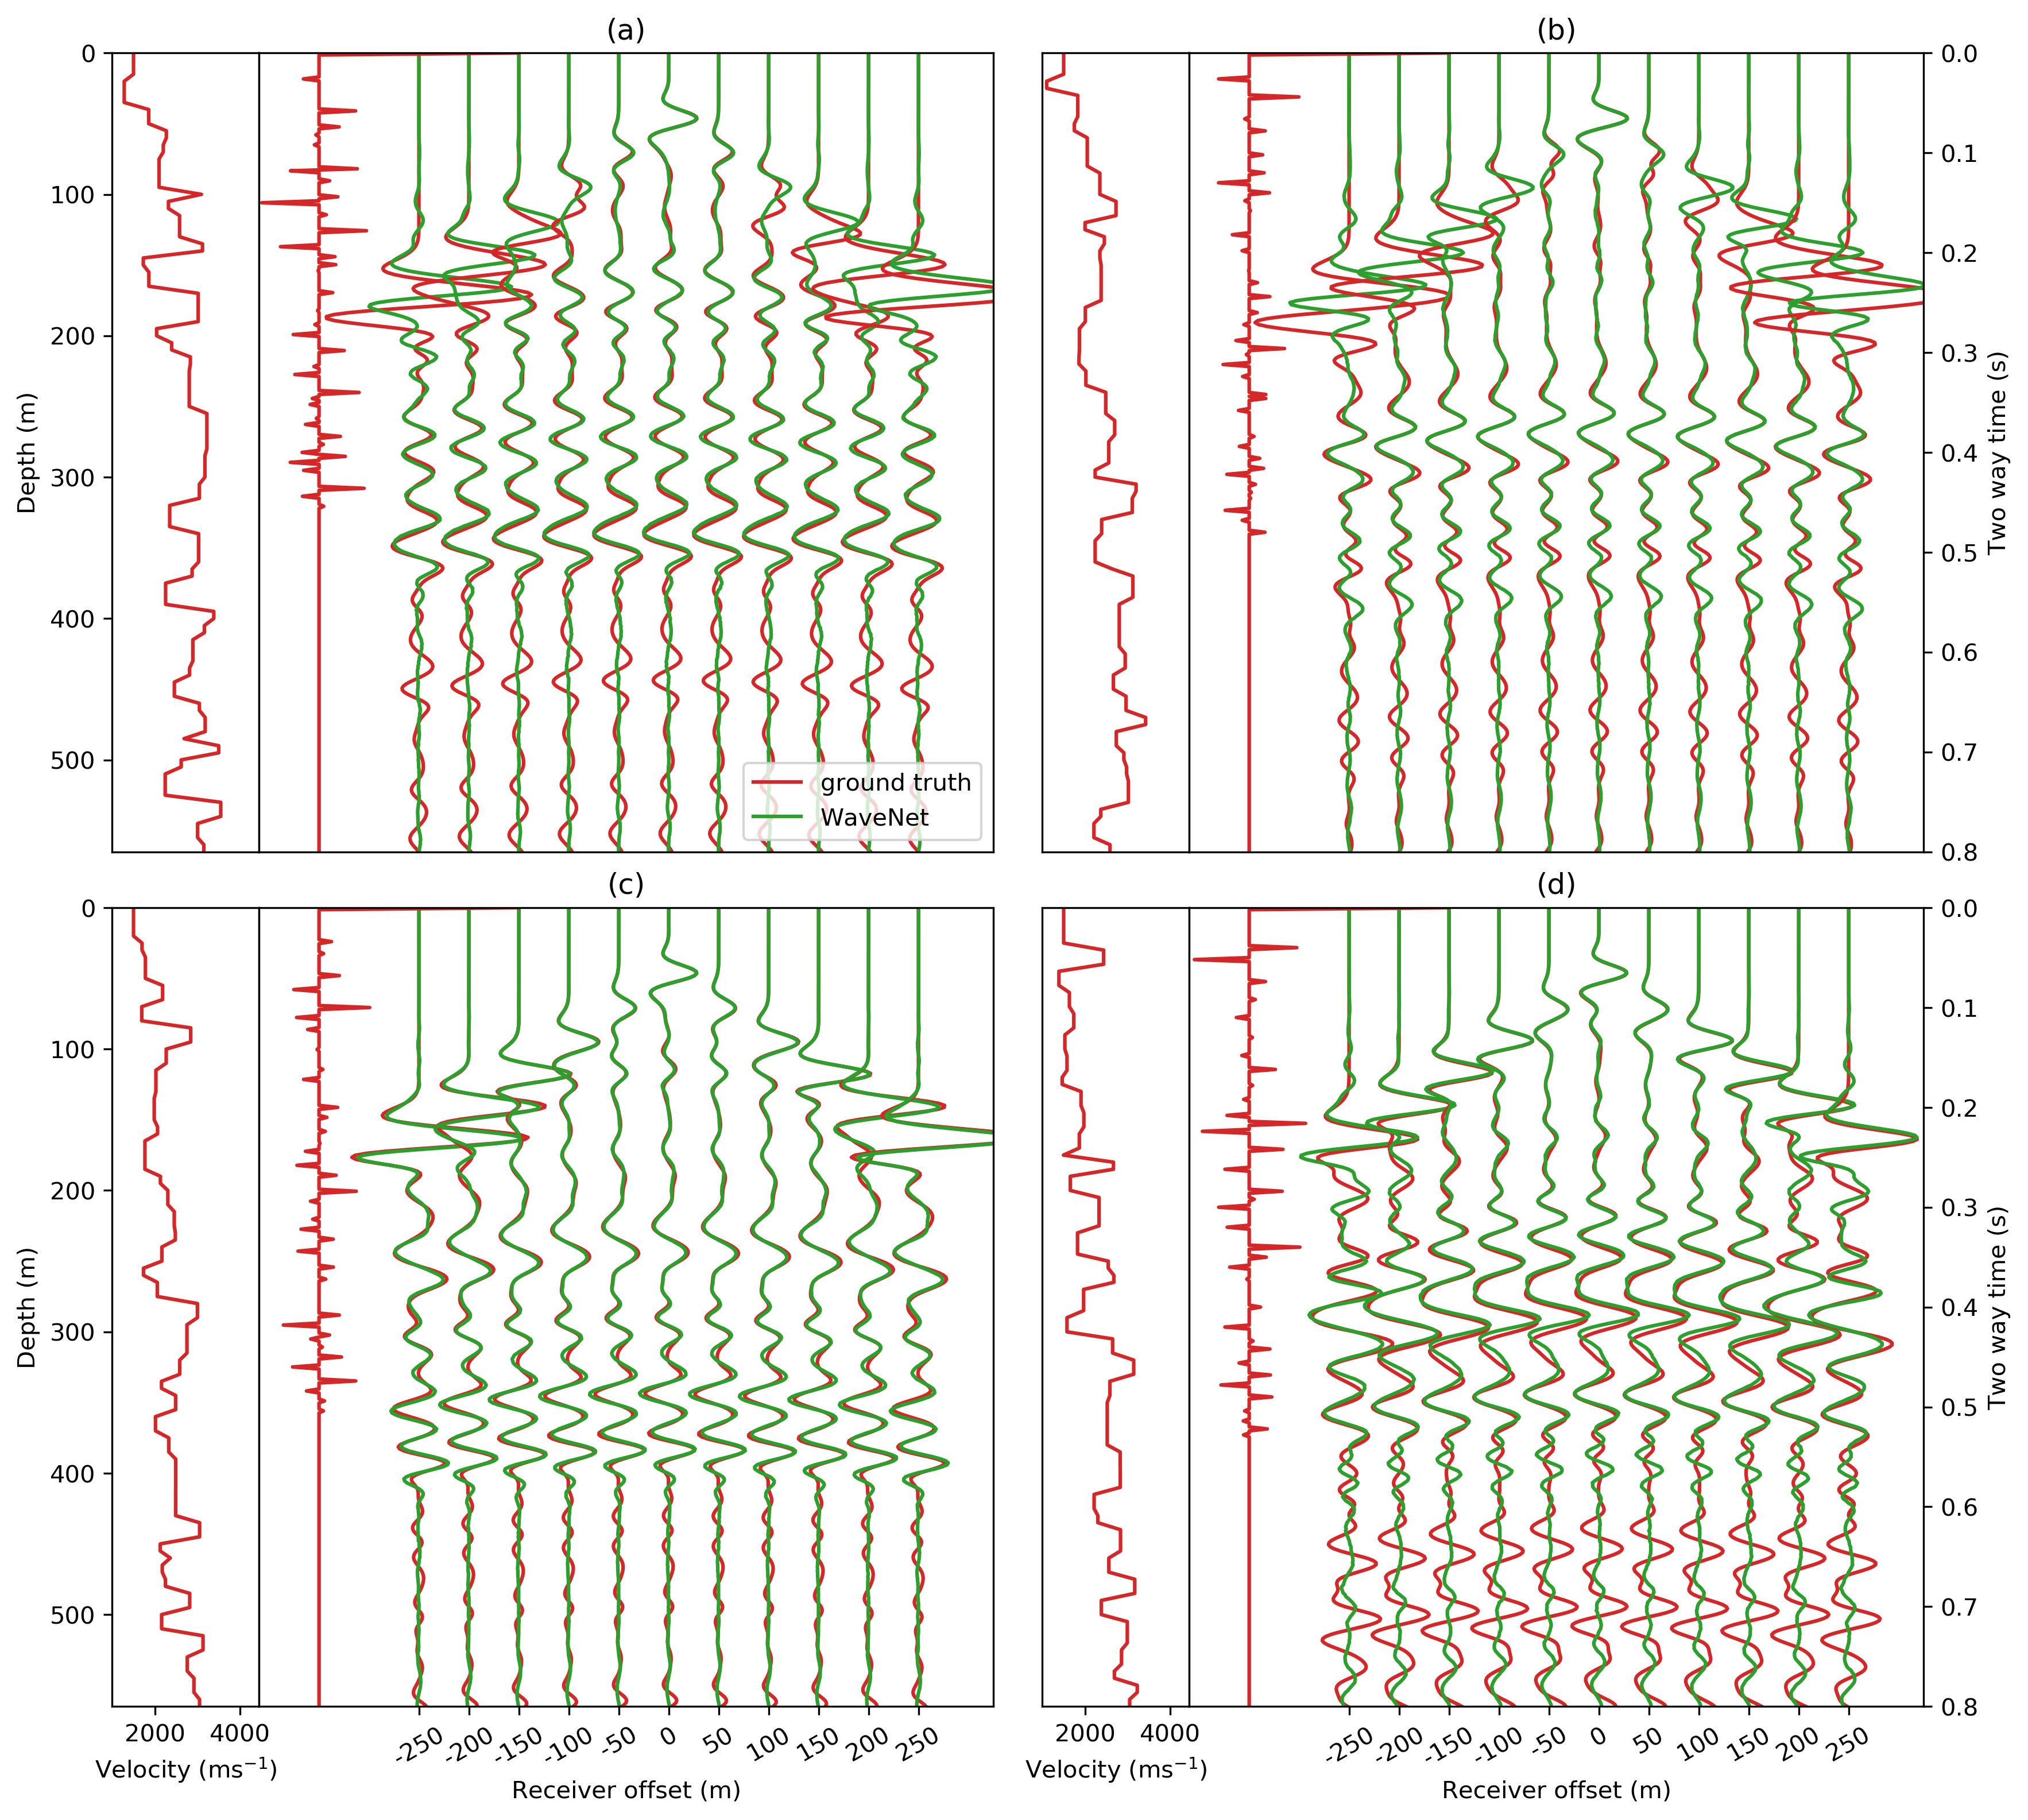

In [17]:
plt.figure(figsize=(12,12), dpi=300)

row_n = 0
for i,ib in enumerate([0,1,2,3]):
    if i == 2:
        row_n = 1
        i = 0
    if i == 3:
        i = 1
    
    # velocity
    plt.subplot2grid((2, 38), (row_n, 0+15*i+3*i+i), colspan=3)
    plt.plot(velocity_array[ib,:,0], DZ*np.arange(NZ), color='tab:red')
    
    plt.gca().invert_yaxis()
    if row_n == 1: plt.xlabel("Velocity ($\mathrm{ms}^{-1}$)")
    else: plt.xticks([])
    plt.xlim(1000,4450)
    plt.ylim(DZ*(NZ-1),0)
    if i==0: plt.ylabel("Depth (m)")
    else: plt.yticks([])
    
    
    # gather & reflectivity
    lim = 1.
    plt.subplot2grid((2, 38), (row_n, 3+15*i+3*i+i), colspan=15)
    for ir in range(NREC): 
        if ib == ir == 0:
            label1="ground truth"
            label2="WaveNet"
        else: label1 = label2 = None
                    
        plt.plot(lim*ir+gain*gather_array[ib,:,ir], DT*np.arange(NSTEPS), color='tab:red',label=label1)
        plt.plot(lim*ir+gain*gather_prediction_array[ib,:,ir], DT*np.arange(NSTEPS), color='tab:green',label=label2)
    
    plt.plot(-2*lim+4*reflectivity_array[ib,:,0], DT*np.arange(NSTEPS), color='tab:red')
    
    if ib == 0: plt.legend(loc=4)
    plt.title("(%s)"%(letters[ib]))
    plt.gca().invert_yaxis()
    if row_n == 1: 
        plt.xlabel("Receiver offset (m)")
        plt.xticks(np.arange(0, NREC*lim,lim), [int(-(NREC-1)*DELTARECi*DX/2 + irec*DELTARECi*DX) for irec in range(NREC)])
    else: plt.xticks([])
    if i==1: plt.ylabel("Two way time (s)")
    else: plt.yticks([])
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    plt.ylim(DT*400,0)
    plt.xlim(-3*lim-0.2, lim*(NREC-1)+lim+0.5)
    plt.xticks(rotation=30)

plt.subplots_adjust(left=0.1, right=1., bottom=0.1, top=.9, hspace=0.07, wspace=0.)
plt.savefig("../report_plots/fig06.pdf", bbox_inches='tight', pad_inches=0.01, dpi=300)